# Demo de Algoritmos de Inducción para generar reglas para clasificar datos


In [ ]:
#@title Librerías a usar
import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

import os
import csv

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn import tree

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [ ]:
# @title Acceder al Drive {"single-column":true}

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = '/content/gdrive/MyDrive/demosColab/demoIA/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [ ]:
#@title Cargar datos

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}
separador_decimal = '.' #@param {type:"string"}

# funciones auxiliares

# importa datos
def cargarDatosDF(path, archivo_datos, delimitador_columnas, separador_decimal, mostrarEstadisticas=True):
  if os.path.isfile( path + '/' + archivo_datos ):
    # existe el archivo
    if ((delimitador_columnas is None) or (delimitador_columnas=="")):
      # si no se define asume ","
      delimitador_columnas = ","
    if ((separador_decimal is None) or (separador_decimal=="")):
      # si no se define asume "."
      separador_decimal = "."
    if (delimitador_columnas==separador_decimal):
      # ambos delimitadores iguales, cambia el decimal
      if delimitador_columnas == ",":
        separador_decimal = "."
      else:
        separador_decimal = ","
      print("- Ambos delimitadores configurados igual, se cambia separador decimal a '" + separador_decimal + "'!")
    # carga datos
    df = pd.read_csv(path + archivo_datos,
                     sep=delimitador_columnas, decimal=separador_decimal,
                     skip_blank_lines=True,
                     engine="python")
    print("> Archivo de datos", archivo_datos, "cargado")
    # muestra estadísticas
    if mostrarEstadisticas:
      print("\n> Cabecera: ")
      print(df.head())
      print("\n> Características: ")
      print(df.describe())
      print("\n")
    # controla que el archivo tenga sentido
    if len(df.columns.values.tolist())<2:
      print("\n> El archivo de datos debería tener al menos 2 columnas, revise delimitador de columnas!")
      return None
    else:
      return df
  else:
    print("No existe archivo de datos ", archivo_datos, "!")
    return None

# importa definición axiliar de las clases (si existe)
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    # si existe, carga los datos
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    # no encontrado
    return "", ""

# inicializa valores
X = None
Y = None
X_att_entrada = None

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## aplicación de los parámetros elegidos

# Carga los datos del CSV y muestra los primeros
df = cargarDatosDF(path, archivo_datos,
                   delimitador_columnas, separador_decimal, mostrarEstadisticas=True)

if df is not None:

  # intenta cargar configuración asociada a los datos
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

  # muestra interface para cargar configuración de los parámetros

  # función auxiliara para que no ejecute UI cada vez
  def hacerNada():
      return

  # se define esta función para que se ocupe de aplicar la configuración
  def on_buttonAplicar_clicked(b):
      print("")
      funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

  # aplica configuración de datos
  def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
      global Y, X, nombre_clases, X_att_entrada

      if (attClase is None) or (attClase =="") or\
        (att_entrada is None) or (att_entrada ==""):
        return

      # si el atributo clase está como de entrada, lo saca (no tiene sentido)
      att_entrada = list(att_entrada)
      if (attClase in att_entrada):
        print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
        att_entrada.remove( attClase )
      X_att_entrada = list(att_entrada)

      if (att_entrada == "") or (len(att_entrada)==0):
        print("No se han definido atributos de entrada!")
        return

      # guarda configuración
      nombre_clases = nomClases

      # genera los datos solo con los atributos seleccionados
      # para clase
      if (attClase in df):
        Y = np.array(df[attClase])
      else:
        print("Atributo " + attClase + " no encontrado !")
        X = None
        Y = None
        return
      # para entrada
      X = np.array(df[att_entrada])

      # muestra resultados
      print("\n> Atributos entrada: ", att_entrada)
      print("\t X: ", X.shape)

      if (nombre_clases is None) or (nombre_clases==""):
        print("\n> Atributo clase: ", attClase)
      else:
        print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
      print("\t Y: ", Y.shape)

  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}

  tit = widgets.Label("Ajuste para configuración de los Datos: ")

  # prepara combo para determinar atributo clase
  selecc_atributos = [ ]
  selecc_atributos.extend( df.columns.values.tolist() )
  if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
    att_selecc_defecto = len(selecc_atributos)-1
  else:
    att_selecc_defecto = selecc_atributos.index(atributo_clase)
  combo_att_clase = widgets.Dropdown(
      options = selecc_atributos,
      value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
      description = 'Atributo clase:',
      style=style_3D,
      disabled = False,
  )
  # prepara campo para ingresar nombre clases (toma por defecto de config)
  texto_nomClases = widgets.Text(
      value=nombre_clases,
      placeholder='Ingrese nombre clases (si corresponde) separados por comas',
      description='Nombre clases:',
      style=style_3D,
      disabled=False
  )

  combo_att_entrada = widgets.SelectMultiple(
      options=selecc_atributos,
      value=selecc_atributos,
      #rows=10,
      description='Atributos de entrada:',
      style=style_3D,
      disabled=False
  )

  # prepara botón y grilla con objetos
  btnAplicar = widgets.Button(
      description='Aplicar'
  )
  configDatos_ui = widgets.GridBox(
        children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
        layout=Layout(width='100%')  )
  btnAplicar.on_click(on_buttonAplicar_clicked)

  #clear_output()
  out_config = widgets.interactive_output(hacerNada, {})
  display(configDatos_ui)

  # ejecuta para que muestre
  on_buttonAplicar_clicked(btnAplicar)


> Archivo de datos IRIS.csv cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


In [ ]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "discreto - CLASIFICACION" #@param ["discreto - CLASIFICACION" ]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100.0

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# inicializa listas
x_train, x_test, y_train, y_test = [], [], [], []
y_trainEnc, y_testEnc = [], []

# control aque haya datos definidos
assert (X is not None), "No se cargaron datos de atributos de entrada!"
assert (len(X)>0), "No se cargaron datos de atributos de entrada!"
assert (Y is not None), "No se cargaron datos de atributo clase!"
assert (len(Y)>0), "No se cargaron datos de atributos de entrada!"

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("** No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  ## CLASIFICAR
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
    # toma los valores de clase orginales del archivo
    if str(Y[0]).replace(".","").isnumeric():
      # Y son números
      print("-- Utiliza valores numéricos como clase.")
      for val in range(int(np.max(Y))+1):
        CLASES.append( "clase {:>3}".format(val) )
    else:
        # Y no son números
        print("-- Utiliza valores alfanuméricos como clase.")
        CLASES = list(set(Y))
        CLASES.sort()
        # cambia valores para que sean enteros
        y_train = [ CLASES.index(y) for y in y_train]
        y_test = [ CLASES.index(y) for y in y_test]
  else:
    # toma configuración de nombre de clases
    print("-- Utiliza nombres de clase definidos.")
    for val in nombre_clases.split(','):
      CLASES.append( val )

  # controla, con advertencias
  if len(CLASES) == 0:
    print("** No se encontraron clases!\n")
  elif len(CLASES) > 10:
    print("** Se detectaron más de 10 clases, revise los datos y el tipo de problema seleccionado!\n")

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES )
else:
  ## ESTIMAR
  print("> se considera problema de ESTIMACIÓN \n")
  if not(str(Y[0]).replace(".","").isnumeric()):
    print("-- Detecta valores alfanuméricos en atributo clase -> convierte a númerico:")
    CLASES = list(set(Y))
    CLASES.sort()
    # cambia valores para que sean enteros
    y_train = [ CLASES.index(y) for y in y_train]
    y_test = [ CLASES.index(y) for y in y_test]
    print(" - dictMapeo (", len(CLASES), "): ", [ str(i) + " : " +CLASES[i]  for i in range(len(CLASES)) ] )

# convierte a numpy para usar por modelo
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# muestra ejemplos
print("\n> Datos para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    print("    ", CLASES[i], "[", i, "]:", np.sum(y_train == i))

print("\n Datos para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    print("    ", CLASES[i], "[", i, "]:", np.sum(y_test == i))
print("")


> se considera problema de CLASIFICACIÓN 

-- Utiliza nombres de clase definidos.
> Definición de CLASES: 
 - dictMapeo ( 4 ):  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Datos para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112
     na [ 0 ]: 0
     Setosa [ 1 ]: 38
     Versicolor [ 2 ]: 37
     Virginica [ 3 ]: 37

 Datos para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38
     na [ 0 ]: 0
     Setosa [ 1 ]: 12
     Versicolor [ 2 ]: 13
     Virginica [ 3 ]: 13



# Modelo:

In [ ]:
#@title Aplicar Algoritmo de Inducción

# parámetros

param_criterio = "Entropy" #@param ["Entropy", "Error", "Gini impurity"]
if param_criterio == "Entropy":
  pCriteria = "entropy"
elif param_criterio == "Error":
  pCriteria = "log_loss"
#elif param_criterio == "Gini impurity":
else:
  pCriteria = "gini"
param_max_depth = 0 #@param {type:"number"}
if param_max_depth < 1:
    # menor que 1 es opcional
    param_max_depth = None
param_split_strategy = "Best" #@param ["Best", "Random"]
if param_split_strategy== "Best":
  pSpliter = "best"
#elif param_split_strategy == "Random":
else:
  pSpliter = "random"
param_min_samples_split  = 0 #@param {type:"number"}
if param_min_samples_split  < 2:
    param_min_samples_split  = 2
param_min_samples_leaf  = 1 #@param {type:"number"}
if param_min_samples_leaf  < 1:
    param_min_samples_leaf  = 1
param_max_leaf_nodes = 0 #@param {type:"number"}
if param_max_leaf_nodes < 2:
    param_max_leaf_nodes = None

# genera el árbol y lo muestra
model = tree.DecisionTreeClassifier(criterion=pCriteria,
                                  splitter=pSpliter,
                                  max_depth=param_max_depth,
                                  min_samples_split=param_min_samples_split,
                                  min_samples_leaf=param_min_samples_leaf,
                                  max_leaf_nodes=param_max_leaf_nodes)
model = model.fit(x_train, y_train)

# muestra las reglas
r = tree.export_text(model,
                     feature_names= list(X_att_entrada),
                     spacing=5, decimals=2)

print("> Reglas:" )
print(r)




> Reglas:
|----- LargoPetalo <= 2.60
|     |----- class: 1
|----- LargoPetalo >  2.60
|     |----- LargoPetalo <= 4.75
|     |     |----- class: 2
|     |----- LargoPetalo >  4.75
|     |     |----- LargoPetalo <= 5.05
|     |     |     |----- LargoSepalo <= 6.50
|     |     |     |     |----- AnchoSepalo <= 3.10
|     |     |     |     |     |----- class: 3
|     |     |     |     |----- AnchoSepalo >  3.10
|     |     |     |     |     |----- class: 2
|     |     |     |----- LargoSepalo >  6.50
|     |     |     |     |----- class: 2
|     |     |----- LargoPetalo >  5.05
|     |     |     |----- class: 3



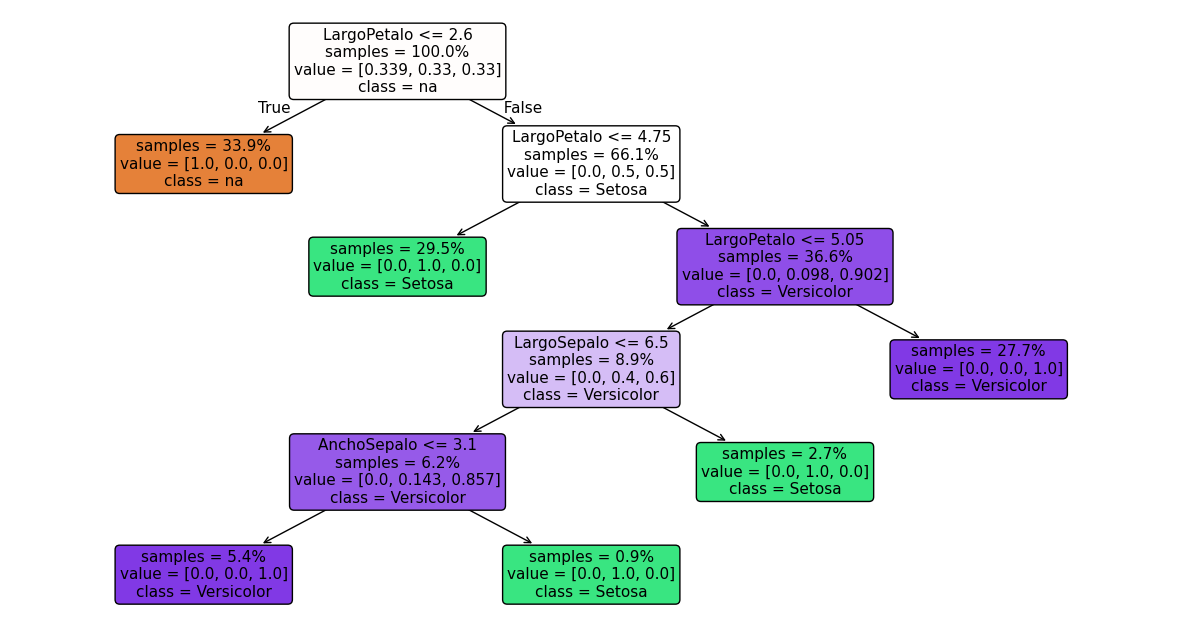

In [ ]:
#@title Mostrar Árbol de Decisión


# muestra el árbol
plt.figure(figsize=(15,8))
tree.plot_tree(model,
              feature_names=X_att_entrada,
              class_names=CLASES,
              label='all',
              impurity=False,
              proportion=True,
              rounded=True,
              filled=True,
              fontsize=11)
plt.show()


### Evaluación del Modelo:

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        38
  Versicolor       1.00      1.00      1.00        37
   Virginica       1.00      1.00      1.00        37

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112


Matriz de Confusión ( real / modelo ): 
              m:Setosa  m:Versicolor  m:Virginica  m:na
r:Setosa            38             0            0     0
r:Versicolor         0            37            0     0
r:Virginica          0             0           37     0
r:na                 0             0            0     0




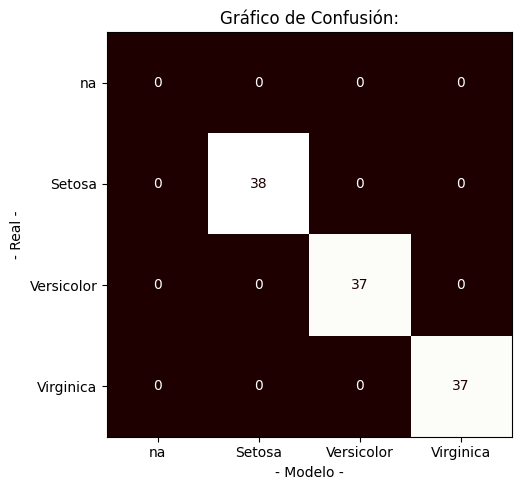

In [ ]:
#@title Evaluar con datos de entrenamiento

mostrar_detalle_entrenamiento = False #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}


def generaResumen_Clasificacion(classReal, classPreds, clases_labels):
    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))
    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_labels)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_labels],
        columns=['m:{:}'.format(x) for x in clases_labels]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")
    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clases_labels)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()
    return

# función auxiliar para probar el modelo entrenado en detalle
def analizarModelo_Clasificacion(datosX, datosY, predsY, clases_map=None, tipo_output_softMax=False, umbralClas=0.5, mostrarDetalle=False, inclDatosEntrada=False):
    # hace copia de classMap por si hay clases inválidas
    if clases_map is None:
      dict_clases_map = {}
    else:
      dict_clases_map = dict(enumerate(clases_map))
    # muestra títulos
    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo [resultado]")
      else:
        print(" Clase Real / Clase Modelo [resultado]")
    # procesa
    classPreds = []
    classReal = []
    for x, rId, pV in zip(datosX, datosY, predsY):
      # determina nombre clase real (agrega si no existe)
      clReal, dict_clases_map = asignarClassName(rId, dict_clases_map)
      # determina el ID de clase predecida
      pId = interpretarPredsModelo(pV, esProblemaClasificacion=True,
                                  tipo_output_softMax=tipo_output_softMax, umbralClas=umbralClas)
      # asigna nombre de clase (agrega si no existe)
      clPred, dict_clases_map = asignarClassName(pId, dict_clases_map)
      # agrega a listas
      classReal.append( clReal )
      classPreds.append( clPred )
      # muestra
      if mostrarDetalle:
        strCompara = "  "
        if inclDatosEntrada:
          strCompara = strCompara + str(x) + '-> '
        strCompara = strCompara +" R: {} [{}] / M: {} [{}]".format(clReal, rId, clPred, pV)
        strCompara = strCompara + " -> " + ("OK" if (clPred==clReal) else "ERROR!") + " "
        print(strCompara)
    # define lista de valores de clases
    clases_labels = list(dict_clases_map.values())
    # muestra matrices resumen
    generaResumen_Clasificacion(classReal, classPreds, clases_labels)
    return

# función que asigna nombre de clase en base a Id
# (si no existe lo agrega)
def asignarClassName(classId, dict_clases_map):
  if (classId in dict_clases_map):
    # nombre existe
    clName = dict_clases_map[classId]
  else:
    # nombre no existe, agrega
    clName = "CLASE " + str(classId) + " INVÁLIDA"
    dict_clases_map[classId] = clName
  # devuelve
  return clName, dict_clases_map

# función que interpreta resultados modelo
# de acuerdo a tipo de problem y configuración de clases
def interpretarPredsModelo(predY, esProblemaClasificacion=True, tipo_output_softMax=False, umbralClas=0.5):
  # devuelve Id de clase correspondiente
  return predY

# método general para evaluar modelo
def evaluarModelo(modelo, esProblemaClasificacion, datosX, datosY, clases_map=None, tipo_output_softMax=False, umbralClas=0.5, mostrarDetalle=False, inclDatosEntrada=False):
    # procesa los datos de entrada con el modelo
    predsY = modelo.predict(datosX)
    # muestra resultados
    analizarModelo_Clasificacion(datosX, datosY, predsY,
                                   clases_map=clases_map, umbralClas=umbralClas,
                                   tipo_output_softMax=tipo_output_softMax,
                                   mostrarDetalle=mostrarDetalle, inclDatosEntrada=inclDatosEntrada)

    return

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
evaluarModelo(model, esProblemaClasificacion=True,
              datosX=x_train, datosY=y_train, clases_map=CLASES,
              mostrarDetalle=mostrar_detalle_entrenamiento,
              inclDatosEntrada=incluirDatosEntrada_detalle_entrenamiento)




*** Resultados con datos de Prueba: 
  Datos Entrada -> Clase Real / Clase Modelo [resultado]
  [5.  3.  1.6 0.2]->  R: Setosa [1] / M: Setosa [1] -> OK 
  [5.5 3.5 1.3 0.2]->  R: Setosa [1] / M: Setosa [1] -> OK 
  [6.5 3.  5.5 1.8]->  R: Virginica [3] / M: Virginica [3] -> OK 
  [4.6 3.4 1.4 0.3]->  R: Setosa [1] / M: Setosa [1] -> OK 
  [5.7 2.8 4.5 1.3]->  R: Versicolor [2] / M: Versicolor [2] -> OK 
  [5.9 3.  4.2 1.5]->  R: Versicolor [2] / M: Versicolor [2] -> OK 
  [6.5 3.  5.8 2.2]->  R: Virginica [3] / M: Virginica [3] -> OK 
  [5.7 2.8 4.1 1.3]->  R: Versicolor [2] / M: Versicolor [2] -> OK 
  [6.  2.7 5.1 1.6]->  R: Versicolor [2] / M: Virginica [3] -> ERROR! 
  [5.4 3.4 1.5 0.4]->  R: Setosa [1] / M: Setosa [1] -> OK 
  [6.7 3.3 5.7 2.5]->  R: Virginica [3] / M: Virginica [3] -> OK 
  [6.7 3.1 4.7 1.5]->  R: Versicolor [2] / M: Versicolor [2] -> OK 
  [6.3 2.5 4.9 1.5]->  R: Versicolor [2] / M: Virginica [3] -> ERROR! 
  [7.2 3.2 6.  1.8]->  R: Virginica [3] / M: Virgini

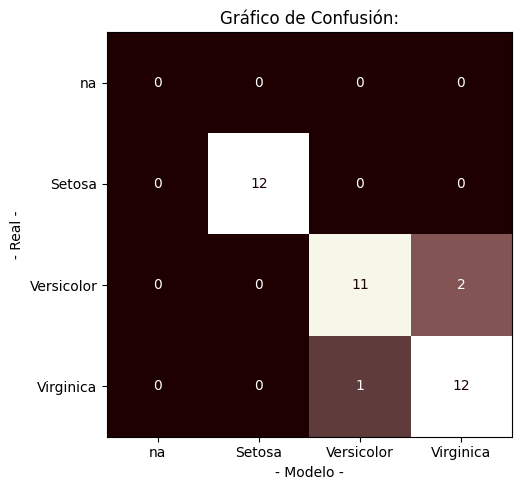

In [ ]:
#@title Evaluar con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = True #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
# muestra resultados
evaluarModelo(model, esProblemaClasificacion=True,
              datosX=x_test, datosY=y_test, clases_map=CLASES,
              mostrarDetalle=mostrar_detalle_prueba,
              inclDatosEntrada=incluirDatosEntrada_detalle_prueba)
